In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import sklearn.metrics as m
import numba as nb
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema
import os
import subprocess
from importlib import reload

import boost_histogram as bh
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import mplhep as hep
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

import os, sys
#sys.path.insert(1, '/data/pku/home/licq/cH/zz_v2/selection/analyzer')

# Fit workflow
Continue from the ROOT file in coffea workflow and make further selections for fit

In [5]:
plot_info = { # order is important
    'HC_4FSFxFx':   (['HC_4FSFxFx'], 'H+c $(\kappa_c=%d)$', 'red'),
    'HC_4FS':   (['HC_4FS'], 'H+c (4FS) $(\kappa_c=%d)$', 'violet'),
    'HC_3FS':   (['HC_3FS'], 'H+c (3FS) $(\kappa_c=%d)$', 'blueviolet'),
    'ggH':  (['ggH'], r'$gg\to H$', 'lightpink'),
    'VBFH': (['VBFH'], r'EW $qqH$', 'thistle'),
    'WH':   (['WminusH', 'WplusH'], r'$WH$', 'hotpink'),
    'ZH':   (['ZH'], r'$ZH$', 'deeppink'),
    'ttH':  (['ttH'], r'$t\bar{t}H$', 'violet'),
    'bbH':  (['bbH'], r'$b\bar{b}H$', 'mediumorchid'),
    'tqH':  (['tqH'], r'$tqH$', 'darkviolet'),
    'qqZZ': (['qqZZ'], r'$q\bar{q}\to ZZ,\,Z\gamma*$', 'lightskyblue'),
    'ggZZ': (['ggZZTo4e', 'ggZZTo4mu', 'ggZZTo4tau', 'ggZZTo2e2mu', 'ggZZTo2e2tau', 'ggZZTo2mu2tau'], r'$gg\to ZZ,\,Z\gamma*$', 'royalblue'),
    'ZX':   (['ZX'], 'Z+X', 'green'),
}

In [7]:
def make_plot_from_root(
    title, nbin, xmin, xmax, content_expr='df.mass4l', selection_expr=None,
    do_flv_mode=False, plot_fileset='all',
    xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 2 GeV', ylog=False, custom_command=None, store_dir=False):

    root_dir = '../samples/slimmed/mc/2018/'
    # Make plots
    f, ax = plt.subplots(figsize=(10, 10))
    hep.cms.label(data=True, llabel='Preliminary', year=2018, ax=ax, fontname='sans-serif') # llabel='Work in progress'

    plot_bkg_info = {k: v for k, v in plot_info.items() if not k.startswith('HC_')}
    plot_sig_info = {k: v for k, v in plot_info.items() if k.startswith('HC_')}
    if plot_fileset != 'all':
        for cat, (samlist, _, _) in plot_bkg_info.copy().items():
            if any(s not in plot_fileset for s in samlist):
                del plot_bkg_info[cat]

    if do_flv_mode:
        def color_fader(c1, c2, mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
            mix = min(1., mix)
            c1=np.array(mpl.colors.to_rgb(c1))
            c2=np.array(mpl.colors.to_rgb(c2))
            return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
        _plot_bkg_info = {
            'HC_4FSFxFx_c':   (['HC_4FSFxFx_c'], 'H+c (c) $(\kappa_c=1)$', color_fader('red', 'black', 0.02)),
            'HC_4FSFxFx_b':   (['HC_4FSFxFx_b'], 'H+c (b) $(\kappa_c=1)$', color_fader('red', 'blue', 0.2)),
            'HC_4FSFxFx_l':   (['HC_4FSFxFx_l'], 'H+c (l) $(\kappa_c=1)$', color_fader('red', 'yellow', 0.2)),
        }
        for cat in plot_bkg_info:
            if cat == 'ggH':
                _plot_bkg_info.update({
                    'ggH_c':  (['ggH_c'], r'$gg\to H$ (c)', color_fader('lightpink', 'black', 0.02)),
                    'ggH_b':  (['ggH_b'], r'$gg\to H$ (b)', color_fader('lightpink', 'blue', 0.2)),
                    'ggH_l':  (['ggH_l'], r'$gg\to H$ (l)', color_fader('lightpink', 'yellow', 0.2)),
                })
            else:
                _plot_bkg_info[cat] = plot_bkg_info[cat]
        plot_bkg_info = _plot_bkg_info
        plot_sig_info = {}

    histkey = list(plot_bkg_info.keys())[::-1]
    # get weighted boost histogram
    hist = {}
    for cat, (samlist, _, _) in {**plot_bkg_info, **plot_sig_info}.items():
        df = uproot.lazy(f"{root_dir}/{cat}.root")
        var, weight = eval(content_expr), df['weight']
        selection = eval(selection_expr) if selection_expr else np.ones_like(weight, dtype=bool)
        hist[cat] = bh.Histogram(bh.axis.Regular(nbin, xmin, xmax), storage=bh.storage.Weight())
        hist[cat].fill(var[selection], weight=weight[selection])

    hist_add = sum([hist[cat] for cat in plot_bkg_info.keys()])

    # make stacked plot
    hep.histplot(
        [hist[k].view().value for k in histkey], 
        bins=hist_add.axes[0].edges,
        yerr=[np.sqrt(hist[k].view().variance) for k in histkey],
        label=[plot_bkg_info[k][1] + ' (%.2f)'%sum(hist[k].view().value) for k in histkey], color=[plot_bkg_info[k][2] for k in histkey], 
        histtype='fill', edgecolor='k', linewidth=1, stack=True,
    )

    # plot signal stat uncertainties
    bkgtot, bkgtot_err = hist_add.view(flow=False).value, np.sqrt(hist_add.view(flow=False).variance)
    ax.fill_between(hist_add.axes[0].edges, (bkgtot-bkgtot_err).tolist()+[0], (bkgtot+bkgtot_err).tolist()+[0], label='BKG stat. unce.', step='post', hatch='///', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.

    # plot signal
    kc = 10
    for cat in plot_sig_info:
        hep.histplot(
            hist[cat].view().value * kc**2,
            bins=hist_add.axes[0].edges,
            yerr=np.sqrt(hist[cat].view().variance) * kc**2,
            label=plot_sig_info[cat][1] % kc, color=plot_sig_info[cat][2], 
        )
#         print('sig', hist[samsig].view().value, 'bkgtot', hist_add.view().value, np.sqrt(2*np.sqrt(hist_add.view().value[0]) / hist[samsig].view().value[0]))

    ax.legend(prop={'size': 18}, ncol=2, labelspacing=0.2, borderpad=0.3)
    ax.set_xlabel(xlabel, ha='right', x=1.0); ax.set_ylabel(ylabel, ha='right', y=1.0);
    
    ax.set_xlim(xmin, xmax); ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    if ylog:
        ax.set_yscale('log')
    if custom_command is not None:
        exec(custom_command)
    
    if isinstance(store_dir, str):
        plt.savefig(store_dir + f'/hist_{title}.jpg')
        plt.savefig(store_dir + f'/hist_{title}.pdf')


In [8]:
# make_plot_from_root(title='ZZMass_wide', nbin=282, xmin=72, xmax=1200, content_expr='df.mass4l', selection_expr=None,
#     do_flv_mode=True, store_dir=False,
#     xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 4 GeV', custom_command="ax.set_xscale('log'); ax.set_xticks([80, 100, 200, 300, 400, 500, 700, 1000]); ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())")

# make_plot_from_root(title='mass4l', nbin=30, xmin=118, xmax=130, content_expr='df.mass4l', selection_expr=None,
#     do_flv_mode=True, store_dir=False,
#     xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 4 GeV')

# make_plot_from_root(title='D_bkg_kin', nbin=40, xmin=0, xmax=1, content_expr='df.D_bkg_kin', selection_expr=None,
#     do_flv_mode=True, store_dir=False,
#     xlabel=r'$D_{bkg}^{kin}$', ylabel='Events / 0.025')

# make_plot_from_root(title='part', nbin=40, xmin=-1, xmax=3, content_expr='df.sv_cand_closest_masscor_log', selection_expr="df.jet_cand_ParticleNet_CvsL >= 0.",
#     do_flv_mode=True, store_dir=False, plot_fileset=['ggH'],
#     xlabel=r'$log(m_{SV\,(closest)}^{corr})$', ylabel='Events / 0.025')

# make_plot_from_root(title='pnet_CvsL', nbin=40, xmin=0.1, xmax=1, content_expr='df.jet_cand_ParticleNet_CvsL', selection_expr="df.jet_cand_ParticleNet_CvsL >= 0",
#     do_flv_mode=False, store_dir="../plots/histo_230216",
#     xlabel=r'Jet ParticleNetAK4 CvsL', ylabel='Events / 0.025')

# make_plot_from_root(title='pnet_CvsB', nbin=40, xmin=0.1, xmax=1, content_expr='df.jet_cand_ParticleNet_CvsB', selection_expr="df.jet_cand_ParticleNet_CvsL >= 0",
#     do_flv_mode=False, store_dir="../plots/histo_230216",
#     xlabel=r'Jet ParticleNetAK4 CvsB', ylabel='Events / 0.025')

# make_plot_from_root(title='bdt_1j', nbin=40, xmin=0., xmax=1, content_expr='df.bdt_1j', selection_expr="df.jet_cand_ParticleNet_CvsL >= 0",
#     do_flv_mode=False, store_dir="../plots/histo_230216",
#     xlabel=r'$BDT_{1j}$', ylabel='Events / 0.025')

# make_plot_from_root(title='pnetSV_CvsL', nbin=40, xmin=0.1, xmax=1, content_expr='(df.sv_cand_ParticleNet_c + df.sv_cand_ParticleNet_cc) / (df.sv_cand_ParticleNet_c + df.sv_cand_ParticleNet_cc + df.sv_cand_ParticleNet_unmat)', selection_expr="(df.jet_cand_pt < 0) & (df.sv_cand_pt > 0)",
#     do_flv_mode=False, store_dir="../plots/histo_230216",
#     xlabel=r'SV ParticleNet CvsL', ylabel='Events / 0.025')

# make_plot_from_root(title='pnetSV_CvsB', nbin=40, xmin=0.1, xmax=1, content_expr='(df.sv_cand_ParticleNet_c + df.sv_cand_ParticleNet_cc) / (df.sv_cand_ParticleNet_c + df.sv_cand_ParticleNet_cc + df.sv_cand_ParticleNet_b + df.sv_cand_ParticleNet_bb)', selection_expr="(df.jet_cand_pt < 0) & (df.sv_cand_pt > 0)",
#     do_flv_mode=False, store_dir="../plots/histo_230216",
#     xlabel=r'SV ParticleNet CvsB', ylabel='Events / 0.025')

# make_plot_from_root(title='bdt_0j', nbin=40, xmin=0., xmax=1, content_expr='df.bdt_0j', selection_expr="(df.jet_cand_pt < 0) & (df.sv_cand_pt > 0)",
#     do_flv_mode=False, store_dir="../plots/histo_230216",
#     xlabel=r'$BDT_{0j}$', ylabel='Events / 0.025')


# custom...
# make_plot_from_root(title='sv_cand_pt', nbin=40, xmin=0, xmax=10, content_expr='df.sv_cand_pt', selection_expr="(df.jet_cand_pt < 0) & (df.sv_cand_pt > 0)",
#     do_flv_mode=False, store_dir="../plots/histo_230216",
#     xlabel=r'SV $p_T$ [GeV]', ylabel='Events / 0.25 GeV')
make_plot_from_root(title='jet_cand_pt', nbin=40, xmin=0, xmax=100, content_expr='df.jet_cand_pt', selection_expr="(df.jet_cand_pt > 0)",
    do_flv_mode=False, store_dir="../plots/histo_230216",
    xlabel=r'Jet $p_T$ [GeV]', ylabel='Events / 2.5 GeV', )#custom_command="ax.set_yscale('log'), ax.set_ylim(1e-2, 1e2)")



findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


## Fit function V1 (simple)

In [ ]:
def do_fit_simple(title,
    vary, nbiny, xminy, xmaxy, content_expry, label='var',
    selection_expr=None,
    do_xsec_fit=False,
    run_flag='1111',
    ):
    root_dir = "../fitspace/std/arrays"
    cmssw_env_cmd = f"source ../script/cmssw_env.sh; cd /home/pku/licq/cH/zz_v2/selection/fitspace/{title}; "
    if not do_xsec_fit:
        fit_fileset = {
            "hig": ['ggH', 'VBFH', 'WH', 'ZH', 'ttH', 'bbH'],
            "hc": ['HC_4FSFxFx'],
            "qqzz": ['qqZZ'],
            "ggzz": ['ggZZ'],
            "zx": ['ZX'],
        }
    else:
        fit_fileset = {
            "higx_c": ['ggH_c', 'HC_4FSFxFx_c'],
            "higx_bl": ['ggH_b', 'ggH_l', 'HC_4FSFxFx_b', 'HC_4FSFxFx_l', 'VBFH', 'WH', 'ZH', 'ttH', 'bbH'],
            "qqzz": ['qqZZ'],
            "ggzz": ['ggZZ'],
            "zx": ['ZX'],
        }
    
    ## 1. Write ROOT file
    if run_flag[0] == '1':
        print('Step 1. Write ROOT file')
        os.makedirs(f"../fitspace/{title}/arrays_fit", exist_ok=True)
        for cat in fit_fileset:
            out_mass4l, out_vary, out_weight = [], [], []
            for sam in fit_fileset[cat]:
                df = uproot.lazy(f"{root_dir}/{sam}.root")
                arrayy = eval(content_expry)
                weight = df['weight']
                selection = eval(selection_expr) if selection_expr else np.ones_like(weight, dtype=bool)
                out_mass4l.append(df.mass4l[selection])
                out_vary.append(arrayy[selection])
                out_weight.append(weight[selection])
            with uproot.recreate(f"../fitspace/{title}/arrays_fit/{cat}.root") as f:
                f["Events"] = {"mass4l": ak.concatenate(out_mass4l, axis=0), vary: ak.concatenate(out_vary, axis=0), "weight": ak.concatenate(out_weight, axis=0)}
        # make plots
        make_plot_from_root(title='mass4l', nbin=30, xmin=118, xmax=130, content_expr='df.mass4l', selection_expr=selection_expr,
            do_flv_mode=do_xsec_fit, store_dir=f"../fitspace/{title}",
            xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 0.04 GeV')
        make_plot_from_root(title=vary, nbin=nbiny, xmin=xminy, xmax=xmaxy, content_expr=content_expry, selection_expr=selection_expr,
            do_flv_mode=do_xsec_fit, store_dir=f"../fitspace/{title}",
            xlabel=label, ylabel='Events / bin')

    ## 2. Get analytical shape
    if run_flag[1] == '1':
        print('Step 2. Get analytical shape by mass4l fit')
        if not do_xsec_fit:
            out = subprocess.check_output(cmssw_env_cmd + 
                r'''root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_mass4l_hc_simple.cxx\(\"%s\"\)''' % title,
                shell=True).decode().splitlines()
        else:
            out = subprocess.check_output(cmssw_env_cmd + 
                r'''root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_mass4l_xsec_simple.cxx\(\"%s\"\)''' % title,
                shell=True).decode().splitlines()
        for line in out:
            if line.startswith(">>TAG>>"):
                rate = line.replace(">>TAG>>", "")
                break
        with open(f"../fitspace/{title}/rate.txt", "w") as f:
            f.write(rate)
        print(rate)

    ## 3. Write 2D template
    if run_flag[2] == '1':
        print("Step 3. Extract 2D shape and write card")
        with open(f"../fitspace/{title}/rate.txt") as f:
            rate = f.read()
        mass4l_axis = bh.axis.Regular(30, 118, 130)
        y_axis = bh.axis.Regular(nbiny, xminy, xmaxy) if isinstance(nbiny, int) else bh.axis.Variable(nbiny)

        result = []
        for cat in fit_fileset:
            df = uproot.lazy(f"../fitspace/{title}/arrays_fit/{cat}.root")
            h2d = bh.Histogram(mass4l_axis, y_axis, storage=bh.storage.Weight())
            h2d.fill(df.mass4l, df[vary], weight=df.weight)
            for i in range(h2d.values().shape[0]): # loop over mass dimension
                hv_norm = h2d.values()[i]/sum(h2d.values()[i] + 1e-20)
                he_norm = np.sqrt(h2d.variances()[i])/sum(h2d.values()[i] + 1e-20)
                hv_norm = np.maximum(hv_norm, 1e-6)
                he_norm = np.minimum(np.maximum(he_norm, 1e-6), hv_norm)
                result.append([(v, e) for v, e in zip(hv_norm, he_norm)])

        with open(f'../fitspace/{title}/hist_raw.txt', 'w') as f:
            for l in result:
                f.write('  '.join([f'{v:.5E} {e:.5E}' for v, e in l]) + '\n')
        rate_input = ','.join(rate.split())
        if not do_xsec_fit:
            out = subprocess.check_output(cmssw_env_cmd + 
                r'''root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc_simple.cxx\(\{%s\},\"%s\",%d,%f,%f\)''' % (rate_input, vary, nbiny, xminy, xmaxy),
                shell=True).decode().splitlines()
        else:
            out = subprocess.check_output(cmssw_env_cmd + 
                r'''root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_xsec_simple.cxx\(\{%s\},\"%s\",%d,%f,%f\)''' % (rate_input, vary, nbiny, xminy, xmaxy),
                shell=True).decode().splitlines()

        if not do_xsec_fit:
            datacard_path = '../script/input_hc_templ_simple.txt'
        else:
            datacard_path = '../script/input_xsec_templ_simple.txt'
        with open(datacard_path) as f:
            datacard = f.read() % rate
        with open(f'../fitspace/{title}/input.txt', 'w') as f:
            f.write(datacard)

    ## 4. Fit 2D shape
    if run_flag[3] == '1':
        print('Step 4. Fit 2D shape')
        if not do_xsec_fit:
            out = subprocess.check_output(cmssw_env_cmd + 
                r'''combine -M AsymptoticLimits -t -1 --expectSignal 1 --saveWorkspace --freezeParameters a1_hig,a1_hc,a2_hig,a2_hc,b1_ggzz,b1_qqzz,b2_ggzz,b2_qqzz,b3_ggzz,b3_qqzz,l1_zx,l2_zx,mean_hig,mean_hc,n1_hig,n1_hc,n2_hig,n2_hc,nevt_hig,nevt_ggzz,nevt_hc,nevt_qqzz,nevt_zx,weight,width_hig,width_hc -n _cH input.txt | tee fit.log''',
                shell=True).decode().splitlines()
            print(out)
            print(get_limit(out))
        else:
            out = subprocess.check_output(cmssw_env_cmd + 
                r'''combine -M FitDiagnostics --saveShapes --saveWithUncertainties --robustFit=1 --freezeParameters a1_higx_c,a1_higx_bl,a2_higx_c,a2_higx_bl,b1_ggzz,b1_qqzz,b2_ggzz,b2_qqzz,b3_ggzz,b3_qqzz,l1_zx,l2_zx,mean_higx_c,mean_higx_bl,n1_higx_c,n1_higx_bl,n2_higx_c,n2_higx_bl,nevt_higx_c,nevt_ggzz,nevt_higx_bl,nevt_qqzz,nevt_zx,weight,width_higx_c,width_higx_bl -n _ggH input.txt | tee fit.log''',
                shell=True).decode().splitlines()
            print(out)
            print(get_fit_result(out))

            out = subprocess.check_output(cmssw_env_cmd + 
                r'''combine -M AsymptoticLimits -t -1 --expectSignal 1 --saveWorkspace --freezeParameters a1_higx_c,a1_higx_bl,a2_higx_c,a2_higx_bl,b1_ggzz,b1_qqzz,b2_ggzz,b2_qqzz,b3_ggzz,b3_qqzz,l1_zx,l2_zx,mean_higx_c,mean_higx_bl,n1_higx_c,n1_higx_bl,n2_higx_c,n2_higx_bl,nevt_higx_c,nevt_ggzz,nevt_higx_bl,nevt_qqzz,nevt_zx,weight,width_higx_c,width_higx_bl -n _ggH input.txt | tee fit.log''',
                shell=True).decode().splitlines()
            print(out)
            print(get_limit(out))

def get_limit(lines):
    for il, line in enumerate(lines):
        if line.startswith("Expected 50.0%"):
            import re
            limit = float(re.findall('r < (\S+)', line)[0])
            return limit

def get_fit_result(lines):
    for il, line in enumerate(lines):
        if line.startswith("Best fit r:"):
            import re
            out = re.findall('(-?\d+\.?\d*)', line)
            return float(out[0]), float(out[1]), float(out[2]) # central, down, up

In [ ]:
import uproot
a=uproot.open('../fitspace/std/arrays/ggH_b.root')

In [ ]:
a['Events'].keys()

['mass4l',
 'D_bkg_kin',
 'channel',
 'jet_cand_pt',
 'jet_cand_DeepJet_CvsL',
 'jet_cand_DeepJet_CvsB',
 'jet_cand_ParticleNet_CvsL',
 'jet_cand_ParticleNet_CvsB',
 'sv_cand_closest_pt',
 'sv_cand_closest_masscor_log',
 'sv_cand_closest_mass_log',
 'sv_cand_pt',
 'sv_cand_ParticleNet_b',
 'sv_cand_ParticleNet_bb',
 'sv_cand_ParticleNet_c',
 'sv_cand_ParticleNet_cc',
 'sv_cand_ParticleNet_unmat',
 'sv_cand_masscor_log',
 'sv_cand_mass_log',
 'bdt_1j',
 'bdt_0j',
 'weight']

Step 1. Write ROOT file
Step 2. Get analytical shape by mass4l fit


Info in <TCanvas::Print>: png file mass4l_shape.png has been created


0.607021  102.865  34.4594  1.54556  16.3743
Step 3. Extract 2D shape and write card


Info in <TCanvas::Print>: png file datahist.png has been created


Step 4. Fit 2D shape
['/home/pku/licq/cH/zz_v2/selection/fitspace', ' <<< Combine >>> ', '>>> random number generator seed is 123456', '>>> method used is AsymptoticLimits', "WARNING: cannot freeze nuisance parameter nevt_hig if it doesn't exist!", "WARNING: cannot freeze nuisance parameter nevt_ggzz if it doesn't exist!", "WARNING: cannot freeze nuisance parameter nevt_hc if it doesn't exist!", "WARNING: cannot freeze nuisance parameter nevt_qqzz if it doesn't exist!", "WARNING: cannot freeze nuisance parameter nevt_zx if it doesn't exist!", "WARNING: cannot freeze nuisance parameter weight if it doesn't exist!", 'SimNLL created with 1 channels, 0 generic constraints, 5 fast gaussian constraints, 0 fast poisson constraints, 0 fast group constraints, ', 'SimNLL created with 1 channels, 0 generic constraints, 5 fast gaussian constraints, 0 fast poisson constraints, 0 fast group constraints, ', 'SimNLL created with 1 channels, 0 generic constraints, 5 fast gaussian constraints, 0 fast po

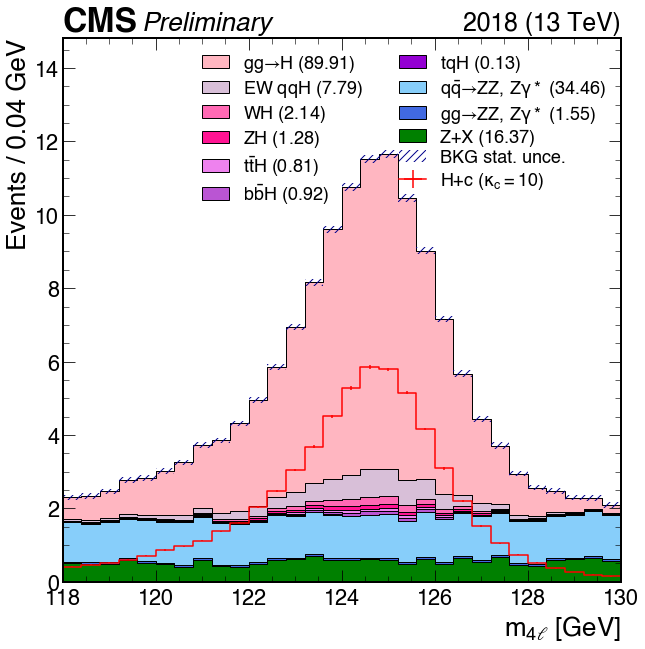

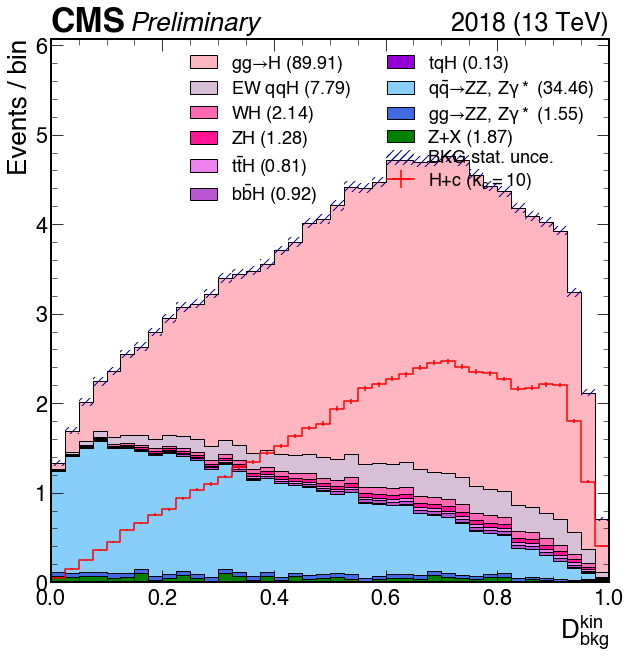

In [ ]:
do_fit_simple(title='simple_dbkg_incl', vary='dbkg', nbiny=40, xminy=0, xmaxy=1, content_expry='df.D_bkg_kin', label=r'$D_{bkg}^{kin}$',
       selection_expr=None,
       run_flag='1111')

# do_fit_simple(title='simple_dbkg_1j', vary='dbkg', nbiny=40, xminy=0, xmaxy=1, content_expry='df.D_bkg_kin', label=r'$D_{bkg}^{kin}$',
#        selection_expr="df.jet_cand_ParticleNet_CvsL >= 0",
#        run_flag='1111')

# do_fit_simple(title='simple_dbkg_1j_pnetcut', vary='dbkg', nbiny=40, xminy=0, xmaxy=1, content_expry='df.D_bkg_kin', label=r'$D_{bkg}^{kin}$',
#        selection_expr="(df.jet_cand_ParticleNet_CvsL >= 0.6) & (df.jet_cand_ParticleNet_CvsB >= 0.2)",
#        run_flag='1111')

# do_fit_simple(title='simple_dbkg_1j_pnetbdtcut', vary='dbkg', nbiny=40, xminy=0, xmaxy=1, content_expry='df.D_bkg_kin', label=r'$D_{bkg}^{kin}$',
#        selection_expr="(df.jet_cand_ParticleNet_CvsL >= 0.6) & (df.jet_cand_ParticleNet_CvsB >= 0.2) & (df.bdt_1j >= 0.45)",
#        run_flag='1111')


# do_fit(title='xsec_dbkg_incl', do_xsec_fit=True, vary='dbkg', nbiny=40, xminy=0, xmaxy=1, content_expry='df.D_bkg_kin', label=r'$D_{bkg}^{kin}$',
#        selection_expr="df.mass4l >= 0",
#        run_flag='1111')

# do_fit(title='xsec_jet_pnet_CvsL_incl', do_xsec_fit=True, vary='jet_pnet_CvsL', nbiny=40, xminy=0, xmaxy=1, content_expry='df.jet_cand_ParticleNet_CvsL', label=r'ParticleNet CvsL',
#        selection_expr="df.jet_cand_ParticleNet_CvsL >= 0",
#        run_flag='1111')

# do_fit(title='xsec_jet_pnet_CvsL_jetwsv', do_xsec_fit=True, vary='jet_pnet_CvsL', nbiny=40, xminy=0, xmaxy=1, content_expry='df.jet_cand_ParticleNet_CvsL', label=r'ParticleNet CvsL',
#        selection_expr="(df.jet_cand_ParticleNet_CvsL >= 0) & (df.sv_cand_closest_masscor_log > -99.)",
#        run_flag='0001')

# do_fit(title='xsec_jet_pnet_CvsL_jet', do_xsec_fit=True, vary='jet_pnet_CvsL', nbiny=40, xminy=0, xmaxy=1, content_expry='df.jet_cand_ParticleNet_CvsL', label=r'ParticleNet CvsL',
#        selection_expr="(df.jet_cand_ParticleNet_CvsL >= 0)",
#        run_flag='1111')

# do_fit(title='xsec_dbkg_jetwsv', do_xsec_fit=True, vary='dbkg', nbiny=40, xminy=0, xmaxy=1, content_expry='df.D_bkg_kin', label=r'$D_{bkg}^{kin}$',
#        selection_expr="(df.jet_cand_ParticleNet_CvsL >= 0) & (df.sv_cand_closest_masscor_log > -99.)",
#        run_flag='1111')

# do_fit(title='xsec_sv_cand_closest_masscor_log_jetwsv', do_xsec_fit=True, vary='sv_cand_closest_masscor_log', nbiny=40, xminy=-1, xmaxy=3, content_expry='df.sv_cand_closest_masscor_log', label=r'$m_{SV\,(closest)}^{corr}$',
#        selection_expr="(df.jet_cand_ParticleNet_CvsL >= 0) & (df.sv_cand_closest_masscor_log > -99.)",
#        run_flag='1111')


## Fit function completed

In [ ]:
def do_fit(title,
    vary, nbiny, xminy, xmaxy, content_expry, label='var',
    selection_expr=None,
    do_xsec_fit=False,
    run_channels=['4mu', '4e', '2mu2e', '2e2mu'],
    params_suffix='',
    run_flag='1111',
    ):

    root_dir = "../samples/predict/mc/"
    cmssw_env_cmd = f"source ../script/cmssw_env.sh; cd /home/pku/licq/cH/zz_v2/selection/fitspace/{title}; "
    channel_idx_map = {"4mu": 1313, "4e": 1111, "2mu2e": 1311, "2e2mu": 1113}

    if not do_xsec_fit:
        fit_fileset = {
            "hc": ['HC_4FSFxFx'],
            'ggh': ['ggH'],
            'vbfh': ['VBFH'],
            'wh': ['WH'],
            'zh': ['ZH'],
            "tth": ['ttH'],
            "bbh": ['bbH'],
            "tqh": ['tqH'],
            "qqzz": ['qqZZ'],
            "ggzz": ['ggZZ'],
            "zx": ['ZX'],
        }
    else:
        fit_fileset = {
            "higx_c": ['ggH_c', 'HC_4FSFxFx_c'],
            "higx_bl": ['ggH_b', 'ggH_l', 'HC_4FSFxFx_b', 'HC_4FSFxFx_l', 'VBFH', 'VH', 'ttH', 'bbH'],
            "qqzz": ['qqZZ'],
            "ggzz": ['ggZZ'],
            "zx": ['ZX'],
        }
    
    ## 1. Write ROOT file
    if run_flag[0] == '1':
        print('Step 1. Write ROOT file')
        for ch in run_channels:
            if selection_expr is None:
                selection_ch_expr = "df.channel == " + str(channel_idx_map[ch])
            else:
                selection_ch_expr = f"({selection_expr}) & (df.channel == {channel_idx_map[ch]})"
            os.makedirs(f"../fitspace/{title}/arrays_fit/{ch}", exist_ok=True)
            for cat in fit_fileset:
                out_mass4l, out_vary, out_weight = [], [], []
                for sam in fit_fileset[cat]:
                    df = uproot.lazy(f"{root_dir}/{sam}.root")
                    arrayy = eval(content_expry)
                    weight = df['weight']
                    selection = eval(selection_ch_expr) if selection_ch_expr else np.ones_like(weight, dtype=bool)
                    out_mass4l.append(df.mass4l[selection])
                    out_vary.append(arrayy[selection])
                    out_weight.append(weight[selection])
                with uproot.recreate(f"../fitspace/{title}/arrays_fit/{ch}/{cat}.root") as f:
                    f["Events"] = {"mass4l": ak.concatenate(out_mass4l, axis=0), vary: ak.concatenate(out_vary, axis=0), "weight": ak.concatenate(out_weight, axis=0)}
            # make plots
            make_plot_from_root(title=f'mass4l_{ch}', nbin=30, xmin=118, xmax=130, content_expr='df.mass4l', selection_expr=selection_ch_expr,
                do_flv_mode=do_xsec_fit, store_dir=f"../fitspace/{title}",
                xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 0.04 GeV')
            make_plot_from_root(title=f'{vary}_{ch}', nbin=nbiny, xmin=xminy, xmax=xmaxy, content_expr=content_expry, selection_expr=selection_ch_expr,
                do_flv_mode=do_xsec_fit, store_dir=f"../fitspace/{title}",
                xlabel=label, ylabel='Events / bin')
        make_plot_from_root(title='mass4l', nbin=30, xmin=118, xmax=130, content_expr='df.mass4l', selection_expr=selection_expr,
            do_flv_mode=do_xsec_fit, store_dir=f"../fitspace/{title}",
            xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 0.04 GeV')
        make_plot_from_root(title=vary, nbin=nbiny, xmin=xminy, xmax=xmaxy, content_expr=content_expry, selection_expr=selection_expr,
            do_flv_mode=do_xsec_fit, store_dir=f"../fitspace/{title}",
            xlabel=label, ylabel='Events / bin')

    ## 2. Get analytical shape
    if run_flag[1] == '1':
        print('Step 2. Get analytical shape by mass4l fit')
        for ch in run_channels:
            if not do_xsec_fit:
                out = subprocess.check_output(cmssw_env_cmd + 
                    r'''root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_mass4l_hc.cxx+\(\"%s\",\"%s\",\"%s\"\)''' % (title, ch, params_suffix),
                    shell=True).decode().splitlines()
            else:
                out = subprocess.check_output(cmssw_env_cmd + 
                    r'''root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_mass4l_xsec.cxx\(\"%s\"\)''' % title,
                    shell=True).decode().splitlines()
            for line in out:
                if line.startswith(">>TAG>>"):
                    rate = line.replace(">>TAG>>", "")
                    break
            with open(f"../fitspace/{title}/rate_{ch}.txt", "w") as f:
                f.write(rate)
            print(rate)

    ## 3. Write 2D template
    if run_flag[2] == '1':
        print("Step 3. Extract 2D shape and write card")
        for ch in run_channels:
            with open(f"../fitspace/{title}/rate_{ch}.txt") as f:
                rate = f.read()

            mass4l_axis = bh.axis.Regular(30, 118, 130)
            y_axis = bh.axis.Regular(nbiny, xminy, xmaxy) if isinstance(nbiny, int) else bh.axis.Variable(nbiny)

            result = []
            for cat in fit_fileset:
                df = uproot.lazy(f"../fitspace/{title}/arrays_fit/{ch}/{cat}.root")
                h2d = bh.Histogram(mass4l_axis, y_axis, storage=bh.storage.Weight())
                h2d.fill(df.mass4l, df[vary], weight=df.weight)
                for i in range(h2d.values().shape[0]): # loop over mass dimension
                    hv_norm = h2d.values()[i]/(sum(h2d.values()[i]) + 1e-20)
                    he_norm = np.sqrt(h2d.variances()[i])/(sum(h2d.values()[i]) + 1e-20)
                    hv_norm = np.maximum(hv_norm, 1e-6)
                    he_norm = np.minimum(np.maximum(he_norm, 1e-6), hv_norm)
                    result.append([(v, e) for v, e in zip(hv_norm, he_norm)])

            with open(f'../fitspace/{title}/hist_raw_{ch}.txt', 'w') as f:
                for l in result:
                    f.write('  '.join([f'{v:.5E} {e:.5E}' for v, e in l]) + '\n')
            rate_input = ','.join(rate.split())
            if not do_xsec_fit:
                print(r'''root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{%s\},\"%s\",%d,%f,%f,\"%s\",\"%s\"\)''' % (rate_input, vary, nbiny, xminy, xmaxy, ch, params_suffix))
                out = subprocess.check_output(cmssw_env_cmd + 
                    r'''root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{%s\},\"%s\",%d,%f,%f,\"%s\",\"%s\"\)''' % (rate_input, vary, nbiny, xminy, xmaxy, ch, params_suffix),
                    shell=True).decode().splitlines()
            else:
                out = subprocess.check_output(cmssw_env_cmd + 
                    r'''root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_xsec.cxx+\(\{%s\},\"%s\",%d,%f,%f\)''' % (rate_input, vary, nbiny, xminy, xmaxy),
                    shell=True).decode().splitlines()

            if not do_xsec_fit:
                # investigate signal uncertainty
                if selection_expr is None:
                    selection_ch_expr = "df.channel == " + str(channel_idx_map[ch])
                else:
                    selection_ch_expr = f"({selection_expr}) & (df.channel == {channel_idx_map[ch]})"
                yields = {}
                for sam in ['HC_4FSFxFx', 'HC_4FS', 'HC_3FS']:
                    df = uproot.lazy(f"{root_dir}/{sam}.root")
                    selection = eval(selection_ch_expr) if selection_ch_expr else np.ones_like(weight, dtype=bool)
                    yields[sam] = ak.sum(df.weight[selection])
                kappa = (0.26 * yields['HC_3FS'] + 0.74 * yields['HC_4FS']) / yields['HC_4FSFxFx']
                assert kappa < 1.
                print(yields['HC_3FS'], yields['HC_4FS'], yields['HC_4FSFxFx'], kappa)

                import cards.input_hc_templ as input_hc_templ
                input_hc_templ = reload(input_hc_templ)
                templ = (input_hc_templ.base_template + input_hc_templ.customized_params[ch]) % rate
                templ = templ.replace('$PDF_FS_HC$', f'{kappa:.5f}/{2-kappa:.5f}').replace('$SHAPE_FILE$', f'input_ws_{ch}.root')
                with open(f'../fitspace/{title}/input_{ch}.txt', 'w') as f:
                    f.write(templ)

            else:
                datacard_path = '../script/input_xsec_templ.txt'
                with open(datacard_path) as f:
                    datacard = f.read() % rate
                with open(f'../fitspace/{title}/input.txt', 'w') as f:
                    f.write(datacard)
        
        if len(run_channels) == 4:
            out = subprocess.check_output(cmssw_env_cmd + 
                r'''combineCards.py FourMu=input_4mu.txt FourE=input_4e.txt TwoMuTwoE=input_2mu2e.txt TwoETwoMu=input_2e2mu.txt > input.txt; text2workspace.py -m 125 input.txt''',
                shell=True).decode().splitlines()

    ## 4. Fit 2D shape
    if run_flag[3] == '1':
        print('Step 4. Fit 2D shape')
        if not do_xsec_fit:
            out = subprocess.check_output(cmssw_env_cmd + 
                r'''combine -M AsymptoticLimits -t -1 --expectSignal 1 --saveWorkspace --freezeParameters 'rgx{a1_.*},rgx{a2_.*},rgx{n1_.*},rgx{n2_.*},rgx{b1_.*},rgx{b2_.*},rgx{b3_.*},rgx{l1_.*},rgx{l2_.*},rgx{mean_.*},rgx{width_.*}' -n _cH input.txt | tee fit.log''',
                shell=True).decode().splitlines()
            print(out)
            print(get_limit(out))

def get_limit(lines):
    for il, line in enumerate(lines):
        if line.startswith("Expected 50.0%"):
            import re
            limit = float(re.findall('r < (\S+)', line)[0])
            return limit

def get_fit_result(lines):
    for il, line in enumerate(lines):
        if line.startswith("Best fit r:"):
            import re
            out = re.findall('(-?\d+\.?\d*)', line)
            return float(out[0]), float(out[1]), float(out[2]) # central, down, up

Step 1. Write ROOT file
Step 2. Get analytical shape by mass4l fit
0.21902  32.198  2.792  0.748788  0.445952  0.265782  0.333523  0.045417  12.8738  0.637798  7.54754
0.109842  16.3045  1.43924  0.407961  0.241857  0.166117  0.167088  0.0249606  5.69451  0.317983  1.34742
0.12619  18.7152  1.6497  0.462177  0.268442  0.180966  0.191884  0.0278431  6.4213  0.247531  1.96313
0.15197  22.6964  1.91201  0.520896  0.328526  0.195934  0.232261  0.0317164  9.46977  0.342247  5.51623
Step 3. Extract 2D shape and write card
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.21902,32.198,2.792,0.748788,0.445952,0.265782,0.333523,0.045417,12.8738,0.637798,7.54754\},\"dbkg\",40,0.000000,1.000000,\"4mu\",\"\"\)
0.12603696 0.20089631 0.21901973 0.8283860087296612
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.109842,16.3045,1.43924,0.407961,0.241857,0.166117,0.167088,0.0249606,5.69451,0.317983,1.34742\},\"dbkg\",40,0.000000,1.000000,\"4e

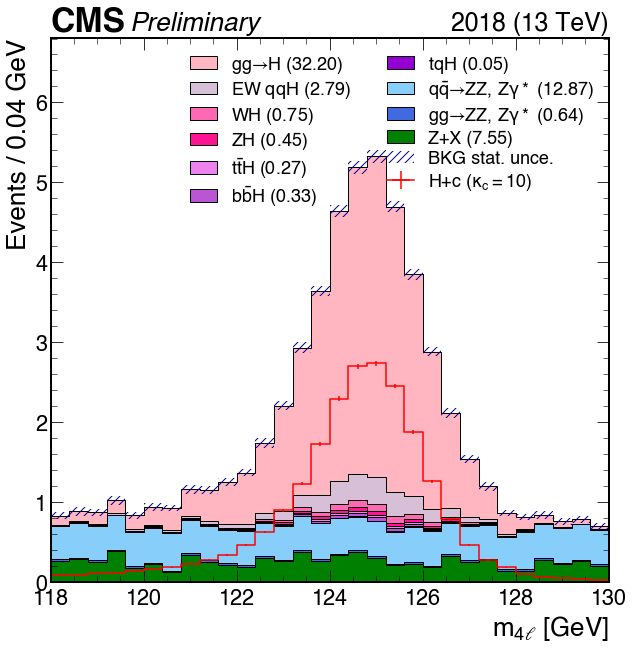

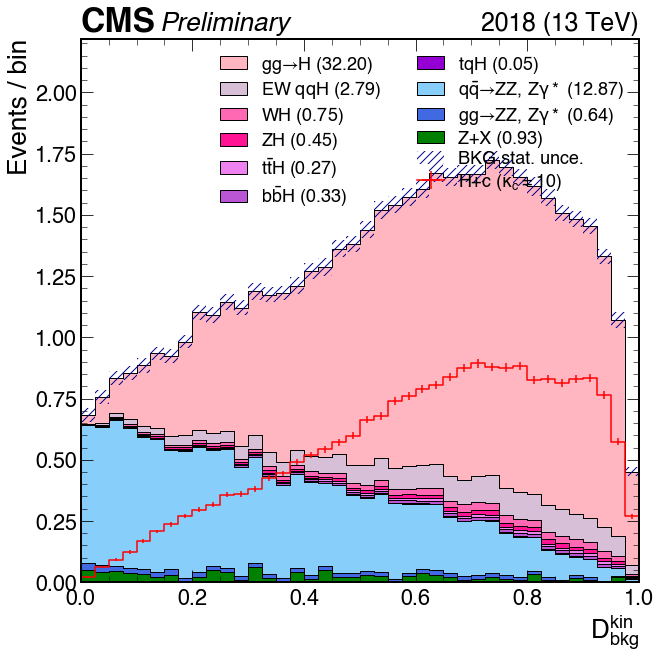

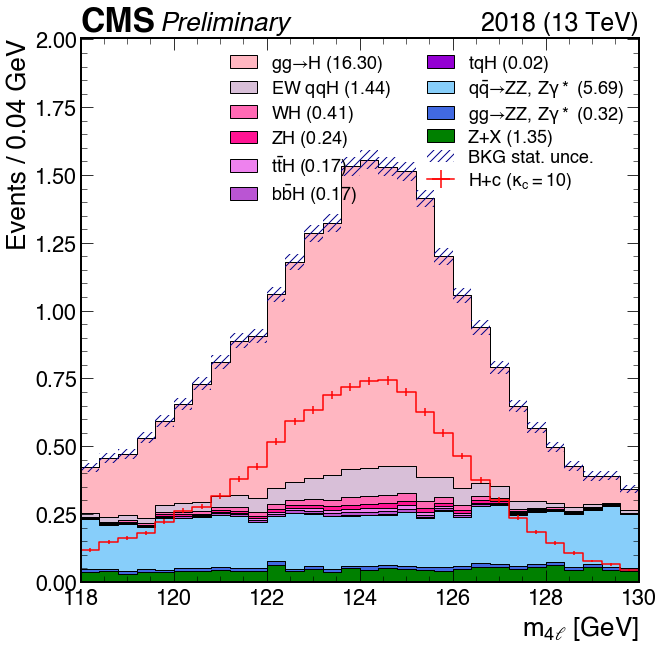

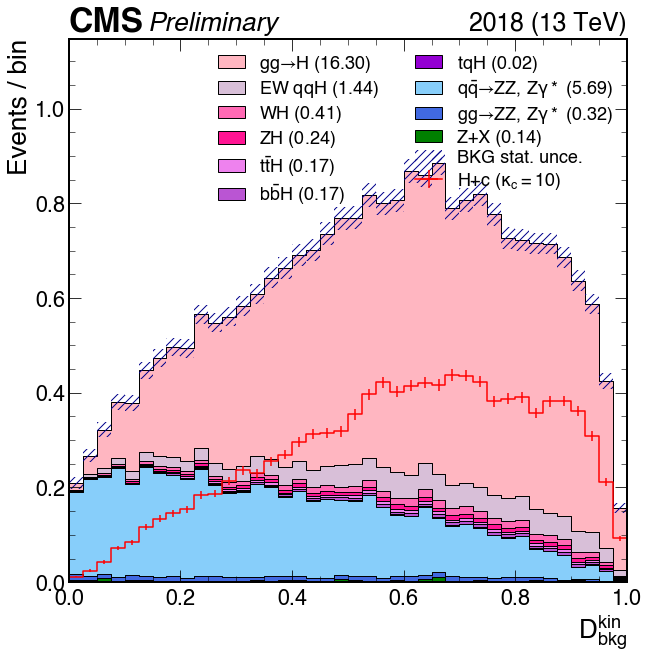

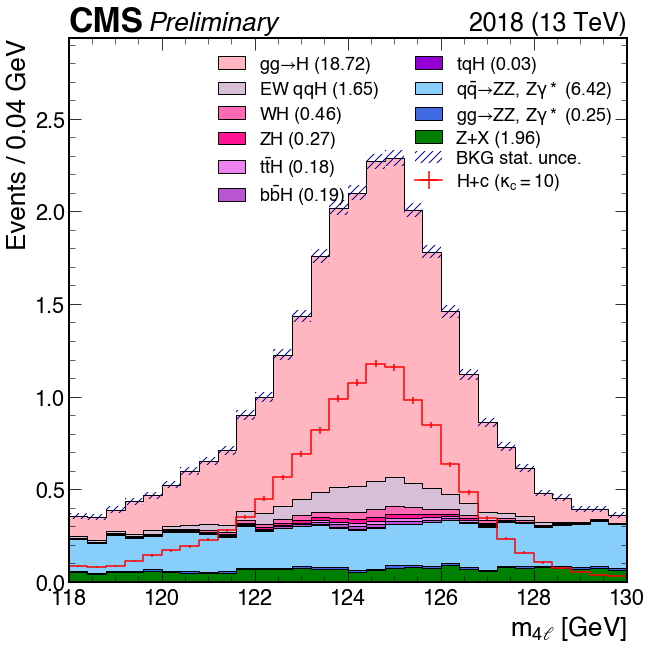

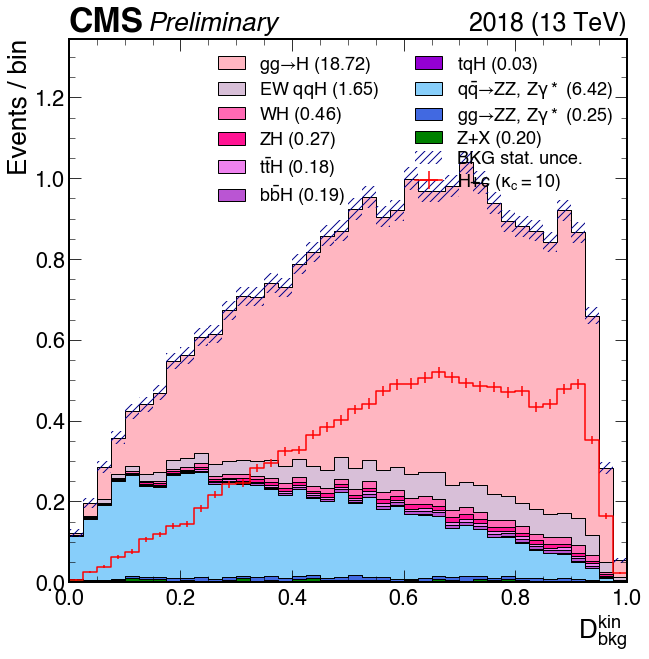

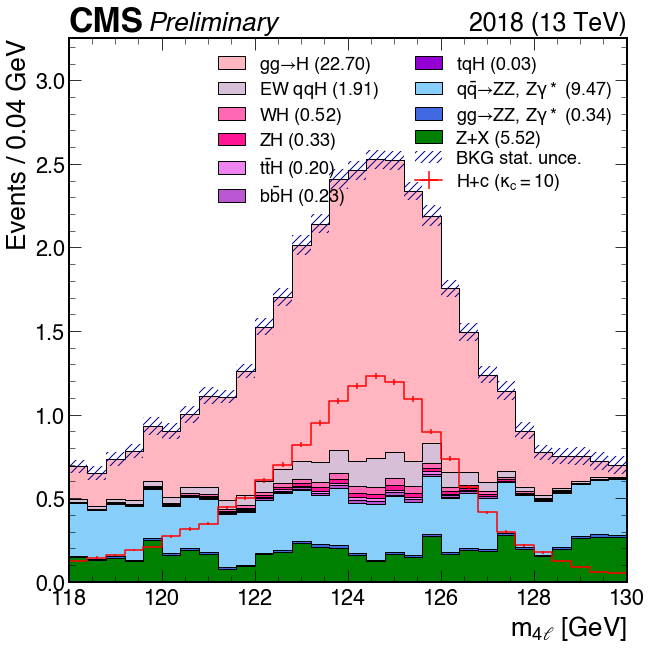

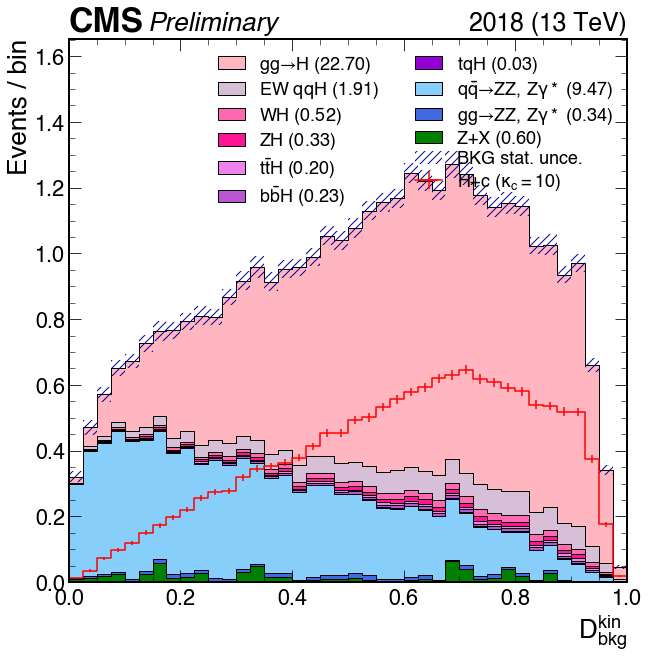

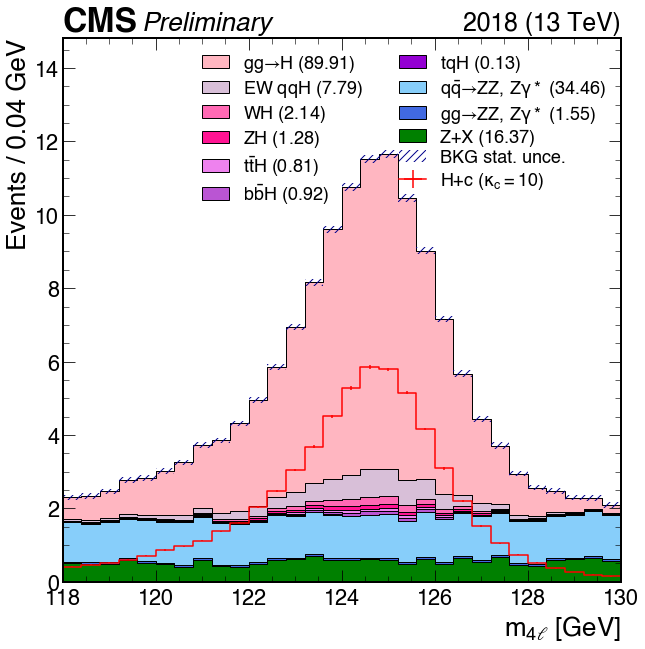

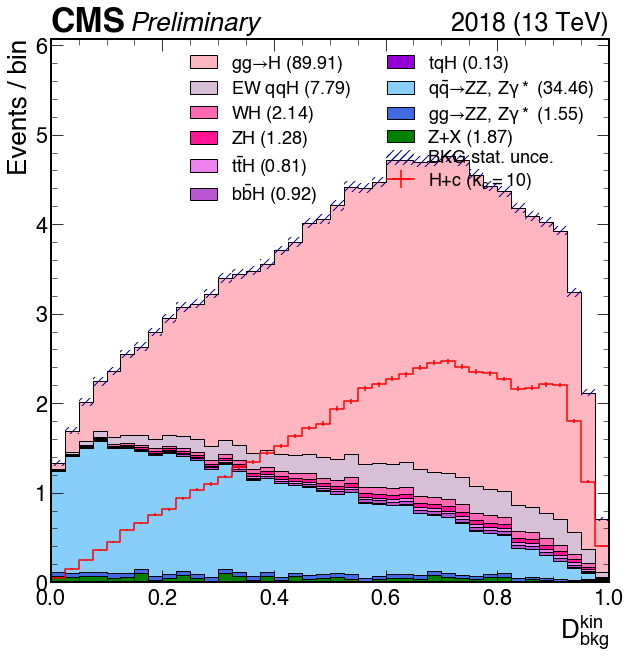

In [ ]:
# do_fit(title='dbkg_1j', vary='dbkg', nbiny=40, xminy=0, xmaxy=1, content_expry='df.D_bkg_kin', label=r'$D_{bkg}^{kin}$',
#        selection_expr="df.jet_cand_ParticleNet_CvsL >= 0",
#        run_flag='0010')

do_fit(title='dbkg_incl', vary='dbkg', nbiny=40, xminy=0, xmaxy=1, content_expry='df.D_bkg_kin', label=r'$D_{bkg}^{kin}$',
       selection_expr=None,
       run_flag='1110')

In [ ]:
do_fit(title='dbkg_1j_pnet_hiBDT_hack', params_suffix='_hi', vary='dbkg', nbiny=40, xminy=0, xmaxy=1, content_expry='df.D_bkg_kin', label=r'$D_{bkg}^{kin}$',
       selection_expr="(df.jet_cand_ParticleNet_CvsL >= 0.6) & (df.jet_cand_ParticleNet_CvsB >= 0.25) & (df.bdt_1j >= 0.45)",
       run_flag='0010')

do_fit(title='dbkg_1j_pnet_loBDT_hack', params_suffix='_lo', vary='dbkg', nbiny=40, xminy=0, xmaxy=1, content_expry='df.D_bkg_kin', label=r'$D_{bkg}^{kin}$',
       selection_expr="(df.jet_cand_ParticleNet_CvsL >= 0.6) & (df.jet_cand_ParticleNet_CvsB >= 0.25) & (df.bdt_1j < 0.45)",
       run_flag='0010')

do_fit(title='dbkg_0j1sv_hiBDT_hack', params_suffix='_0jhi', vary='dbkg', nbiny=40, xminy=0, xmaxy=1, content_expry='df.D_bkg_kin', label=r'$D_{bkg}^{kin}$',
       selection_expr="(df.jet_cand_pt < 0) & (df.sv_cand_pt > 0) & (df.bdt_0j >= 0.4)",
       run_flag='0010')

do_fit(title='dbkg_0j1sv_loBDT_hack', params_suffix='_0jlo', vary='dbkg', nbiny=40, xminy=0, xmaxy=1, content_expry='df.D_bkg_kin', label=r'$D_{bkg}^{kin}$',
       selection_expr="(df.jet_cand_pt < 0) & (df.sv_cand_pt > 0) & (df.bdt_0j < 0.4)",
       run_flag='0010')

Step 3. Extract 2D shape and write card
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.0141692,0.209107,0.0518378,0.0315512,0.0176242,0.023307,0.0150511,0.00211176,0.15715,0.0047575,0.727018\},\"dbkg\",40,0.000000,1.000000,\"4mu\",\"_hi\"\)


Info in <TUnixSystem::ACLiC>: creating shared library /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc_cxx.so
Info in <TCanvas::Print>: png file datahist_4mu.png has been created


0.008365459 0.011442265 0.014169237 0.751084572720756
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.00694976,0.108414,0.0253204,0.0155671,0.00982538,0.0136043,0.00699111,0.0010742,0.0649624,0.00234184,0.0912438\},\"dbkg\",40,0.000000,1.000000,\"4e\",\"_hi\"\)


Info in <TCanvas::Print>: png file datahist_4e.png has been created


0.0049433904 0.0060427347 0.0069497563 0.8283607290246741
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.00802432,0.0978398,0.0337392,0.0184733,0.0107521,0.0165929,0.0082839,0.00124952,0.0688469,0.000755775,0.124028\},\"dbkg\",40,0.000000,1.000000,\"2mu2e\",\"_hi\"\)


Info in <TCanvas::Print>: png file datahist_2mu2e.png has been created


0.0049053365 0.006721095 0.008024324 0.7787569573628386
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.00928704,0.144649,0.0378577,0.0209568,0.0118452,0.0156601,0.00967198,0.00145215,0.0964998,0.00108106,0.4426\},\"dbkg\",40,0.000000,1.000000,\"2e2mu\",\"_hi\"\)


Info in <TCanvas::Print>: png file datahist_2e2mu.png has been created


0.0059989076 0.008318432 0.00928704 0.8307658443244872
Step 3. Extract 2D shape and write card
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.00314775,0.282913,0.102983,0.0561422,0.0281848,0.0684785,0.00803089,0.00664407,0.0638159,0.00140536,0.454686\},\"dbkg\",40,0.000000,1.000000,\"4mu\",\"_lo\"\)


Info in <TCanvas::Print>: png file datahist_4mu.png has been created


0.001974443 0.0019144082 0.003147751 0.6131416256296096
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.00165739,0.129567,0.0531328,0.0317539,0.015136,0.043894,0.00413522,0.00370715,0.020082,0.00115847,0.0442634\},\"dbkg\",40,0.000000,1.000000,\"4e\",\"_lo\"\)


Info in <TCanvas::Print>: png file datahist_4e.png has been created


0.0013439398 0.0009959054 0.0016573917 0.6554843650500538
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.00187619,0.152594,0.0615305,0.0374861,0.0196093,0.0512431,0.00472991,0.00402715,0.015252,0.000704618,0.065519\},\"dbkg\",40,0.000000,1.000000,\"2mu2e\",\"_lo\"\)


Info in <TCanvas::Print>: png file datahist_2mu2e.png has been created


0.0013051151 0.0010771486 0.0018761946 0.6057046910446254
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.00226801,0.203697,0.0621814,0.0392125,0.0205753,0.0518691,0.00578955,0.00453538,0.0285567,0.000355501,0.279216\},\"dbkg\",40,0.000000,1.000000,\"2e2mu\",\"_lo\"\)


Info in <TCanvas::Print>: png file datahist_2e2mu.png has been created


0.0013876169 0.001196562 0.0022680084 0.5494848353694305
Step 3. Extract 2D shape and write card
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.0283904,2.47606,0.0431071,0.00677724,0.00408776,8.93018e-05,0.0347042,0.000243189,1.57127,0.0652533,0.0660884\},\"dbkg\",40,0.000000,1.000000,\"4mu\",\"_0jhi\"\)


Info in <TCanvas::Print>: png file datahist_4mu.png has been created


0.01854451 0.027003305 0.028390404 0.8736761360825646
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.0143655,1.23855,0.0209425,0.00312569,0.00272145,4.37241e-05,0.016569,0.000115565,0.627846,0.0307687,0.00771011\},\"dbkg\",40,0.000000,1.000000,\"4e\",\"_0jhi\"\)


Info in <TCanvas::Print>: png file datahist_4e.png has been created


0.008939675 0.013690952 0.014365488 0.8670516715748802
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.0159411,1.45459,0.0227338,0.00299751,0.00274822,0,0.0204494,0.000136017,0.762312,0.0237071,0.010906\},\"dbkg\",40,0.000000,1.000000,\"2mu2e\",\"_0jhi\"\)


Info in <TCanvas::Print>: png file datahist_2mu2e.png has been created


0.010194942 0.01537255 0.015941119 0.8798863024917382
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.0194942,1.77414,0.0260383,0.00397354,0.00339476,4.85687e-05,0.0228861,0.000144019,1.15892,0.0271201,0\},\"dbkg\",40,0.000000,1.000000,\"2e2mu\",\"_0jhi\"\)


Info in <TCanvas::Print>: png file datahist_2e2mu.png has been created


0.012456584 0.01923931 0.01949418 0.8964625155433984
Step 3. Extract 2D shape and write card
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.00557366,1.39711,0.148466,0.0231137,0.015857,0.000284604,0.0140642,0.000716193,0.298571,0.0316642,0.040832\},\"dbkg\",40,0.000000,1.000000,\"4mu\",\"_0jlo\"\)


Info in <TCanvas::Print>: png file datahist_4mu.png has been created


0.0031366597 0.005322602 0.005573663 0.8529861162051408
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.00293075,0.647648,0.0738597,0.0130747,0.00843436,9.92896e-05,0.00648153,0.000367689,0.152628,0.014827,0.00314384\},\"dbkg\",40,0.000000,1.000000,\"4e\",\"_0jlo\"\)


Info in <TCanvas::Print>: png file datahist_4e.png has been created


0.0016449785 0.002341031 0.0029307464 0.7370332076526955
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.00315762,0.753928,0.0807481,0.0146096,0.0085411,9.61881e-05,0.00705262,0.0004174,0.150973,0.00741667,0.00884761\},\"dbkg\",40,0.000000,1.000000,\"2mu2e\",\"_0jlo\"\)


Info in <TCanvas::Print>: png file datahist_2mu2e.png has been created


0.002288177 0.0030583157 0.0031576161 0.9051384065516686
root -b -q /home/pku/licq/cH/zz_v2/selection/script/prefit_2dtempl_hc.cxx+\(\{0.00361838,0.944472,0.0969194,0.0165216,0.0122489,0,0.0100958,0.000443331,0.220908,0.0162423,0.00731699\},\"dbkg\",40,0.000000,1.000000,\"2e2mu\",\"_0jlo\"\)


Info in <TCanvas::Print>: png file datahist_2e2mu.png has been created


0.001637023 0.0035878278 0.0036183752 0.8513817349077779
